# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [ ]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
from sklearn.preprocessing import FunctionTransformer

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [149]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)

In [3]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

#Shape and head of general data
print("General population shape {}.".format(azdias.shape))
azdias.head()

General population shape (891221, 366).


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
#Shape and head of customers data
print("Customers shape {}.".format(customers.shape))
customers.head()

Customers shape (191652, 369).


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [5]:
#load data with attributes information
feature_info = pd.read_csv('DIAS_Info_Attributes2017.csv', sep=',')

#Shape and head of feature summary
print(feature_info.shape)
print(feature_info.head())
print(feature_info['Information level'].value_counts())

(313, 2)
  Information level             Attribute
0            Person              AGER_TYP
1            Person  ALTERSKATEGORIE_GROB
2            Person             ANREDE_KZ
3            Person         CJT_GESAMTTYP
4            Person     FINANZ_MINIMALIST
PLZ                   114
Person                 75
Microcell (RR3_ID)     55
125m x 125m Grid       33
Microcell (RR4_ID)     12
Building               10
Community               5
RR1_ID                  5
Postcode                4
Name: Information level, dtype: int64


## Preprocessing

### Assess Missing Data

#### Create missing value keys dictionary from 'DIAS Attributs - Values 2017.xlsx'

In [150]:
def create_missing_key_dict(attr_value_file):
    '''
    Read DIAS_Attributes_Values_2017.csv and parse missing and unkonwn keys for all attributes
    
    Input:
        attr_value_file (str): path to DIAS_Attributes_Values_2017.csv file
    
    Output:
        missing_keys_dict (dict): dictionary of attributes with values being an array of missing keys
    '''
    attr_values = pd.read_csv(attr_value_file, sep=',')
    missing_keys = attr_values[attr_values["Meaning"].isin(["unknown","unknown / no main age detectable"])]#, 
#                                                            "no transaction known", "no transactions known"])]

    missing_keys_dict = {}
    for _, row in missing_keys.iterrows():
        key = row["Attribute"]
        missing_keys_dict[key] = row["Value"].split(",")

        #Treat D13_*_RZ values as correponding D13_*
        #Replace D13_*_RZ in dictionary by D13_*
        #if "_RZ" in key:
        #    new_key = key.replace("_RZ", "")
        #    missing_keys_dict[new_key] = missing_keys_dict.pop(key)
    
    no_transaction_attributes = ['D19_BANKEN_DIREKT_RZ', 'D19_BANKEN_GROSS_RZ', 'D19_BANKEN_LOKAL_RZ', 'D19_BANKEN_REST_RZ',
                                 'D19_BEKLEIDUNG_GEH_RZ', 'D19_BEKLEIDUNG_REST_RZ', 'D19_BILDUNG_RZ', 'D19_BIO_OEKO_RZ',
                                 'D19_BUCH_RZ', 'D19_DIGIT_SERV_RZ', 'D19_DROGERIEARTIKEL_RZ', 'D19_ENERGIE_RZ', 
                                 'D19_FREIZEIT_RZ', 'D19_GARTEN_RZ', 'D19_HANDWERK_RZ', 'D19_HAUS_DEKO_RZ', 'D19_KINDERARTIKEL_RZ'
                                 'D19_KOSMETIK_RZ', 'D19_LEBENSMITTEL_RZ', 'D19_LOTTO_RZ', 'D19_NAHRUNGSERGAENZUNG_RZ', 
                                 'D19_RATGEBER_RZ', 'D19_SAMMELARTIKEL_RZ', 'D19_SCHUHE_RZ', 'D19_SONSTIGE_RZ', 
                                 'D19_TECHNIK_RZ', 'D19_TELKO_MOBILE_RZ', 'D19_TELKO_REST_RZ', 'D19_TIERARTIKEL_RZ',
                                 'D19_VERSAND_REST_RZ', 'D19_VERSICHERUNGEN_RZ', 'D19_VOLLSORTIMENT_RZ', 'D19_WEIN_FEINKOST_RZ']

    #[missing_keys_dict[key]=0 for key in no_transaction_attributes]
    
    #Treat D13_*_RZ values as correponding D13_*
    #Replace D13_*_RZ in dictionary by D13_*
    for key in no_transaction_attributes:
        new_key = key.replace("_RZ", "")
        missing_keys_dict[new_key] = ['0']        

    missing_keys_dict["CAMEO_INTL_2015"] = ['XX']
    missing_keys_dict["CAMEO_DEUG_2015"] = ['X','XX']
    missing_keys_dict["CAMEO_DEU_2015"] =['XX']
    
    missing_keys_dict["GEBURTSJAHR"] = ['0']
    
    #add information about missing codes from similar attributes
    missing_keys_dict["CAMEO_INTL_2015"] == missing_keys_dict["CAMEO_DEUINTL_2015"]
    #missing_keys_dict["D19_BANKEN_REST"] == missing_keys_dict["D19_BANKEN_LOKAL"]
    missing_keys_dict["KBA13_CCM_1401_2500"] = missing_keys_dict["KBA13_CCM_1400_2500"]
    missing_keys_dict["KBA13_BAUMAX"] = missing_keys_dict["KBA05_BAUMAX"]
    missing_keys_dict["KBA13_ANTG1"] =  missing_keys_dict["KBA05_ANTG1"]
    missing_keys_dict["KBA13_ANTG2"] =  missing_keys_dict["KBA05_ANTG2"]
    missing_keys_dict["KBA13_ANTG3"] =  missing_keys_dict["KBA05_ANTG3"]
    missing_keys_dict["KBA13_ANTG4"] =  missing_keys_dict["KBA05_ANTG4"]    
    
    #missing_keys_dict["D19_BUCH_CD"] =  missing_keys_dict["D19_BUCH"]  
    
    missing_keys_dict["KOMBIALTER"] = ['9']
    #missing_keys_dict["D19_VERSI_DATUM"] =  missing_keys_dict["D19_VERSAND_DATUM"]
    #missing_keys_dict["D19_VERSI_OFFLINE_DATUM"] =  missing_keys_dict["D19_VERSAND_OFFLINE_DATUM"]    
    #missing_keys_dict["D19_VERSI_ONLINE_DATUM"] =  missing_keys_dict["D19_VERSAND_ONLINE_DATUM"]    
    
    return missing_keys_dict

In [151]:
missing_keys_dict = create_missing_key_dict('DIAS_Attributes_Values_2017.csv') 
print(len(missing_keys_dict))
missing_keys_dict

275


{'AGER_TYP': ['-1'],
 'ALTERSKATEGORIE_GROB': ['-1', ' 0'],
 'ALTER_HH': ['0'],
 'ANREDE_KZ': ['-1', ' 0'],
 'BALLRAUM': ['-1'],
 'BIP_FLAG': ['-1'],
 'CAMEO_DEUG_2015': ['X', 'XX'],
 'CAMEO_DEUINTL_2015': ['-1'],
 'CJT_GESAMTTYP': ['0'],
 'D19_KK_KUNDENTYP': ['-1'],
 'EWDICHTE': ['-1'],
 'FINANZTYP': ['-1'],
 'FINANZ_ANLEGER': ['-1'],
 'FINANZ_HAUSBAUER': ['-1'],
 'FINANZ_MINIMALIST': ['-1'],
 'FINANZ_SPARER': ['-1'],
 'FINANZ_UNAUFFAELLIGER': ['-1'],
 'FINANZ_VORSORGER': ['-1'],
 'GEBAEUDETYP': ['-1', ' 0'],
 'GEOSCORE_KLS7': ['-1', ' 0'],
 'HAUSHALTSSTRUKTUR': ['-1', ' 0'],
 'HEALTH_TYP': ['-1'],
 'HH_EINKOMMEN_SCORE': ['-1', ' 0'],
 'INNENSTADT': ['-1'],
 'KBA05_ALTER1': ['-1', ' 9'],
 'KBA05_ALTER2': ['-1', ' 9'],
 'KBA05_ALTER3': ['-1', ' 9'],
 'KBA05_ALTER4': ['-1', ' 9'],
 'KBA05_ANHANG': ['-1', ' 9'],
 'KBA05_ANTG1': ['-1'],
 'KBA05_ANTG2': ['-1'],
 'KBA05_ANTG3': ['-1'],
 'KBA05_ANTG4': ['-1'],
 'KBA05_AUTOQUOT': ['-1', ' 9'],
 'KBA05_BAUMAX': ['-1', ' 0'],
 'KBA05_CCM1': ['-

1. 'DIAS Attributs - Values 2017.xlsx' file was converted to csv file 'DIAS_Attributes_Values_2017.csv'. 
2. create_missing_code_dict function is created to create dictionary of missings keys for attributes

#### Convert Missing Value Codes to NaNs

In [152]:
#assess initially missing data
missing_info = pd.DataFrame(data=azdias.columns, columns=["Attribute"])

def get_missing_by_column(df):
    '''
    Calculates number of Nan in each column and returns an array of total number of missing values
    
    Input:
        df (DataFrame): Dataset for which columns the missing values will be calculated
        
    Output:
        n_missing_array: array of number of missing valeus
    '''       
    n_missing_array = []
    for col in df.columns:
        #count Nan in azdias
        try:
            n_missing_array.append(df[col].isnull().value_counts()[1])
        except:
            n_missing_array.append(0)   
            
    return n_missing_array
    
missing_info['ini_missing'] = get_missing_by_column(azdias)
missing_info.sort_values(by ="ini_missing", ascending=False)[:20]


,Attribute,ini_missing
7,ALTER_KIND4,890016
6,ALTER_KIND3,885051
5,ALTER_KIND2,861722
4,ALTER_KIND1,810163
100,EXTSEL992,654153
300,KK_KUNDENTYP,584612
8,ALTERSKATEGORIE_FEIN,262947
85,D19_VERSAND_ONLINE_QUOTE_12,257113
62,D19_LOTTO,257113
36,D19_BANKEN_ONLINE_QUOTE_12,257113


In [153]:
def convert_keys_to_nan(df, keys_dict):
    '''
    Replaces given keys from keys_dict to np.nan in df inplace
    
    Input:
        df (DataFrame): Dataset for which keys to np.nan need to be converted
        keys_dict: dictionary of attributes with keys that needs to be converted to np.nan
        
    Output:
        None
    '''
    for attribute in keys_dict:
        if attribute in df.columns:       
            keys_array = keys_dict[attribute]
            #print(attribute, keys_array)
            for key in keys_array:
                if key == 'X' or key == 'XX':
                    key = str(key)
                else:
                    key = int(key)
                    #df[attribute].value_counts()
                df[attribute].replace(key, np.NaN, inplace=True)

        else:
            print("Attribute {} is not available in DataFrame.".format(attribute))

In [154]:
convert_keys_to_nan(azdias, missing_keys_dict)

Attribute BIP_FLAG is not available in DataFrame.
Attribute CAMEO_DEUINTL_2015 is not available in DataFrame.
Attribute D19_KK_KUNDENTYP is not available in DataFrame.
Attribute GEOSCORE_KLS7 is not available in DataFrame.
Attribute HAUSHALTSSTRUKTUR is not available in DataFrame.
Attribute KBA13_CCM_1400_2500 is not available in DataFrame.
Attribute SOHO_FLAG is not available in DataFrame.
Attribute WACHSTUMSGEBIET_NB is not available in DataFrame.
Attribute D19_BUCH is not available in DataFrame.
Attribute D19_KINDERARTIKELD19_KOSMETIK is not available in DataFrame.


In [155]:
missing_info['final_missing'] = get_missing_by_column(azdias)
missing_info.sort_values(by ="final_missing", ascending=False)[:20]


,Attribute,ini_missing,final_missing
7,ALTER_KIND4,890016,890016
349,TITEL_KZ,73499,889061
6,ALTER_KIND3,885051,885051
33,D19_BANKEN_LOKAL,0,874745
5,ALTER_KIND2,861722,861722
43,D19_DIGIT_SERV,0,857661
41,D19_BIO_OEKO,0,854074
79,D19_TIERARTIKEL,0,852220
63,D19_NAHRUNGSERGAENZUNG,0,852176
47,D19_GARTEN,0,851626


#### Assess Missing Data in Each Column

In [156]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
total = azdias.shape[0]
#calculate percent of total missing value by attribute
missing_info['percent_missing'] = missing_info['final_missing']/total*100

#DataFrame of missing attributes sorted from lowest to highest
sorted_missing_info = missing_info.sort_values(by='final_missing', ascending=False)
print(sorted_missing_info.round(2)[:50])

                       Attribute  ini_missing  final_missing  percent_missing
7                    ALTER_KIND4       890016         890016            99.86
349                     TITEL_KZ        73499         889061            99.76
6                    ALTER_KIND3       885051         885051            99.31
33              D19_BANKEN_LOKAL            0         874745            98.15
5                    ALTER_KIND2       861722         861722            96.69
43                D19_DIGIT_SERV            0         857661            96.23
41                  D19_BIO_OEKO            0         854074            95.83
79               D19_TIERARTIKEL            0         852220            95.62
63        D19_NAHRUNGSERGAENZUNG            0         852176            95.62
47                    D19_GARTEN            0         851626            95.56
60              D19_LEBENSMITTEL            0         837914            94.02
95             D19_WEIN_FEINKOST            0         836142    

Text(0.5,1,'Distribution of total missing data ')

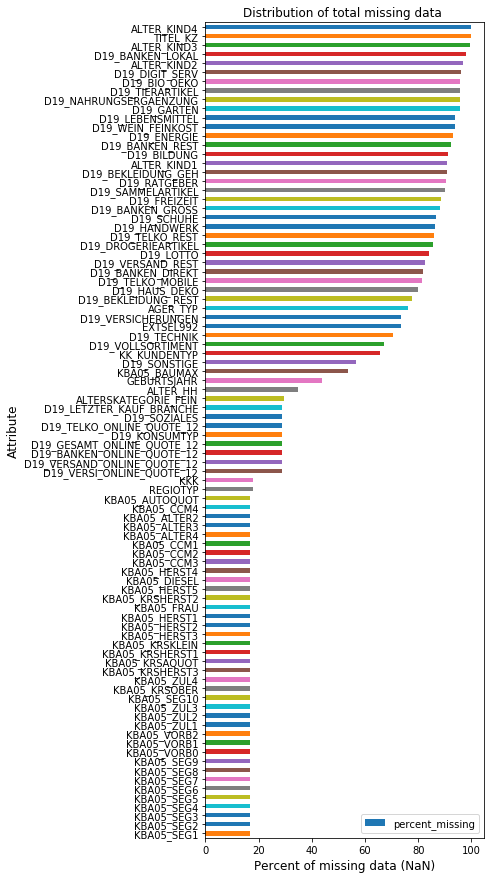

In [157]:
#plot barh plot of final missing values
ax = sorted_missing_info[:90].plot(x = 'Attribute',y = 'percent_missing',  kind='barh', figsize=(5,15))
ax.invert_yaxis()
ax.set_xlabel('Percent of missing data (NaN)', size='large')
ax.set_ylabel('Attribute', size='large');
ax.set_title('Distribution of total missing data ', size='large')

In [158]:
#print attributes with more than 30% percent of missing data
deleted_columns = sorted_missing_info[sorted_missing_info["percent_missing"]>30]["Attribute"].values
print (len(deleted_columns))
print (list(deleted_columns))
print (sorted_missing_info[sorted_missing_info["percent_missing"]>30]["percent_missing"].values.round(2))

41
['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'D19_BANKEN_LOKAL', 'ALTER_KIND2', 'D19_DIGIT_SERV', 'D19_BIO_OEKO', 'D19_TIERARTIKEL', 'D19_NAHRUNGSERGAENZUNG', 'D19_GARTEN', 'D19_LEBENSMITTEL', 'D19_WEIN_FEINKOST', 'D19_ENERGIE', 'D19_BANKEN_REST', 'D19_BILDUNG', 'ALTER_KIND1', 'D19_BEKLEIDUNG_GEH', 'D19_RATGEBER', 'D19_SAMMELARTIKEL', 'D19_FREIZEIT', 'D19_BANKEN_GROSS', 'D19_SCHUHE', 'D19_HANDWERK', 'D19_TELKO_REST', 'D19_DROGERIEARTIKEL', 'D19_LOTTO', 'D19_VERSAND_REST', 'D19_BANKEN_DIREKT', 'D19_TELKO_MOBILE', 'D19_HAUS_DEKO', 'D19_BEKLEIDUNG_REST', 'AGER_TYP', 'D19_VERSICHERUNGEN', 'EXTSEL992', 'D19_TECHNIK', 'D19_VOLLSORTIMENT', 'KK_KUNDENTYP', 'D19_SONSTIGE', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
[ 99.86  99.76  99.31  98.15  96.69  96.23  95.83  95.62  95.62  95.56
  94.02  93.82  93.11  92.21  91.24  90.9   90.81  90.33  90.    88.73
  88.12  86.74  86.22  85.95  85.39  83.92  82.41  81.78  81.55  80.01
  77.7   76.02  73.46  73.4   70.7   67.32  65.6   56.77  53.47  44.02

In [159]:
print (list(deleted_columns))

['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'D19_BANKEN_LOKAL', 'ALTER_KIND2', 'D19_DIGIT_SERV', 'D19_BIO_OEKO', 'D19_TIERARTIKEL', 'D19_NAHRUNGSERGAENZUNG', 'D19_GARTEN', 'D19_LEBENSMITTEL', 'D19_WEIN_FEINKOST', 'D19_ENERGIE', 'D19_BANKEN_REST', 'D19_BILDUNG', 'ALTER_KIND1', 'D19_BEKLEIDUNG_GEH', 'D19_RATGEBER', 'D19_SAMMELARTIKEL', 'D19_FREIZEIT', 'D19_BANKEN_GROSS', 'D19_SCHUHE', 'D19_HANDWERK', 'D19_TELKO_REST', 'D19_DROGERIEARTIKEL', 'D19_LOTTO', 'D19_VERSAND_REST', 'D19_BANKEN_DIREKT', 'D19_TELKO_MOBILE', 'D19_HAUS_DEKO', 'D19_BEKLEIDUNG_REST', 'AGER_TYP', 'D19_VERSICHERUNGEN', 'EXTSEL992', 'D19_TECHNIK', 'D19_VOLLSORTIMENT', 'KK_KUNDENTYP', 'D19_SONSTIGE', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']


In this step I have identified the columns with missing values (np.NaN). The analysis demonstrates that most of the columns have less than 18% of missing data while there are 20 attributes with more than 20% of missing data. Among these attributes are 'ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1','AGER_TYP', 'EXTSEL992', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', these 20 columns need to be removed from analysis.



Besides that, the attributes with similar amount of missing data were identified:
    
    158064  (%17.74): KKK, REGIOTYP
    148115 (%16.62):  most of KBA_05 features
    133324 (%14.96): all RR3 micro-cell features (KBA05_ANTG3, KBA05_ANTG1, KBA05_ANTG2, KBA05_GBZ, KBA05_ANTG4, MOBI_REGIO) 
    116515 (%13.07): all PLZ8 macro-cell features (PLZ8_ANTG2, PLZ8_ANTG1, PLZ8_ANTG3, PLZ8_ANTG4, PLZ8_BAUMAX, PLZ8_HHZ, PLZ8_GBZ)
    111196 missing by code (%12.48): VERS_TYP, SHOPPER_TYP, HEALTH_TYP
    SEMIO_, FINANZ_, AGER_TYP, ALTERSKATEGORIE_GROB, ANREDE_KZ, GEBURTSJAHR, GREEN_AVANTGARDE,
    HEALTH_TYP, NATIONALITAET_KZ and PRAEGENDE_JUGENDJAHRE attributes with zero missing features.

In [160]:
#drop columns with more than 30% of missing data
print(azdias.shape)
azdias.drop(deleted_columns,axis=1,inplace=True)
print(azdias.shape)

(891221, 366)
(891221, 325)


#### Assess Missing Data in Each Row

In [161]:
# How much data is missing in each row of the dataset?
azdias['n_missing'] = azdias.isnull().sum(axis=1)
#df_missing_rows = azdias.isnull().sum(axis=1).sort_values(ascending=False)
print("First 20 rows with the highest missing values: \n", azdias['n_missing'].sort_values(ascending=False)[:20])
print(azdias['n_missing'].describe())


First 20 rows with the highest missing values: 
 826869    253
537799    253
373501    252
55664     252
350182    252
5099      251
522174    251
140317    251
23667     251
228624    251
347712    251
57866     251
332962    251
739769    251
255742    251
716386    251
629707    251
475330    250
474460    249
100757    249
Name: n_missing, dtype: int64
count    891221.000000
mean         33.533933
std          75.577464
min           0.000000
25%           0.000000
50%           1.000000
75%           9.000000
max         253.000000
Name: n_missing, dtype: float64


Text(0,0.5,'Number of rows')

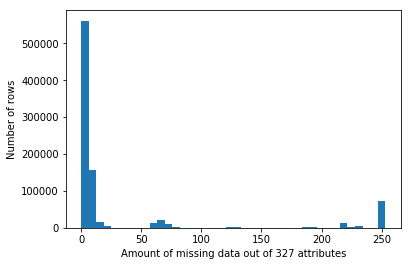

In [17]:
ax = azdias["n_missing"].plot(kind='hist', bins=40)
ax.set_xlabel("Amount of missing data out of {} attributes".format(azdias.shape[1]))
ax.set_ylabel("Number of rows")

In [162]:
#divide the data into two subsets based on the number of missing
# values in each row.
#We will separate at 25 missing attributes
azdias_few_nan = azdias[azdias["n_missing"]<= 25].drop("n_missing", axis=1)
azdias_nan = azdias[azdias["n_missing"]> 25].drop("n_missing", axis=1)

print(azdias_few_nan.shape)
print(azdias_nan.shape)

(736407, 325)
(154814, 325)


Comparison of distribution of values for columns where there are no missing values between No NaN and droped NaN subsets.


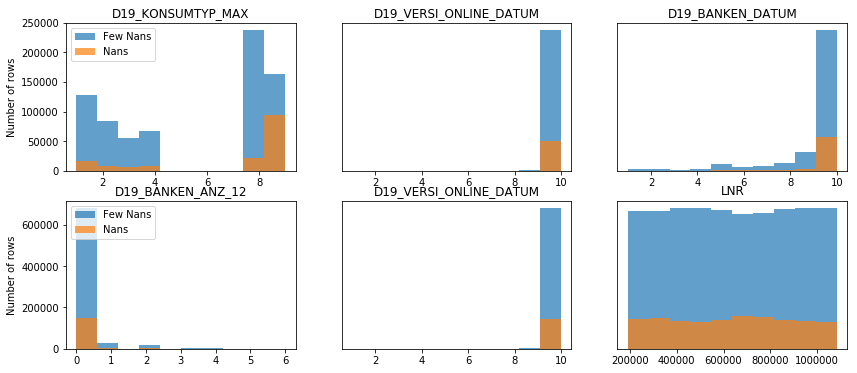

In [19]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
#list of attributes with no missing values
attribute_list  = missing_info[missing_info['final_missing']==0]['Attribute'].values
#print(attribute_list)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 6))

attribute_list = [attribute_list[random.randint(0, len(attribute_list)-1)] for i in range (6)]
#print(attribute_list)
print("Comparison of distribution of values for columns where there are no missing values between No NaN and droped NaN subsets.")
for i, attribute in enumerate(attribute_list[:6]):
    #print(attribute)
    axes_0 = math.trunc(i/3)
    axes_1 = i%3       
    ax = axes[axes_0,axes_1]
    
    azdias_few_nan[attribute].plot(ax = ax,alpha=0.7, kind='hist', label = "Few Nans")
    azdias_nan[attribute].plot(ax = ax,alpha=0.7, kind='hist', label = "Nans")
    ax.set_title(attribute)
    if axes_1 != 0:
        ax.get_yaxis().set_visible(False)
    else:
        ax.set_ylabel("Number of rows")
        ax.legend(loc="upper left")

The maximum number of missing data in each row is 247 attributes out og 346. The distribution of amount of missing data in each row demonstrates that mosst of the rows has less than 25 missing attribute. So, the data was devided into two subsets: azdias_few_nan with <=25 missing attributes (737027 rows) and azdias_nan with >25 missing attributes ( 154194 rows). Comparison of distribution of values for 6 randomly choosen columns demonstrates that there is similar distribution in two data_sets with few missing values (Few Nans) and a lot of NaNs (Nans) 
['D19_BANKEN_ANZ_24', 'LNR', 'D19_BANKEN_DIREKT', 'D19_BANKEN_LOKAL', 'D19_BANKEN_LOKAL', 'D19_BANKEN_DIREKT']

### Select and Re-Encode Features

Identify attributes that correspond to different types:

- numeric and interval data (keep without any changes)
- ordinal data (make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes)
- categorical (keep, drop, or re-encode each)
- mixed(drop, or re-encode each)


In [20]:
description = pd.read_csv('DIAS_Attributes_Values_2017.csv', sep=',')

#carefully look at description of features that 
attribute_with_description =description["Attribute"].unique() 

#treat attributes with D19_*_RZ as corresponding D19_* attributes
attribute_with_description = [att.replace("_RZ", "") for att in attribute_with_description]

#print("Total number of attributes that have description {}.".format(len(attribute_with_description)))

all_attributes = azdias_few_nan.columns
print("Number of attributes that need description (after removing attributes with more than "
      "%18 percent of missing values) {}.".format(len(all_attributes)))

attribute_azdias_description = np.intersect1d(attribute_with_description,all_attributes)
print("Number of attributes that have description {}.".format(len(attribute_azdias_description)))

attributes_with_no_description = np.setdiff1d(all_attributes,attribute_azdias_description, assume_unique=True)
print("Number of attributes without description {}.".format(len(attributes_with_no_description)))    
   
#iterate through values and see what values correspod to attributes with no description
print ("Attributes with missing description:")
for attribute in attributes_with_no_description:
    print(attribute)
    print(azdias_few_nan[attribute].value_counts())

attributes_description_was_not_used = np.setdiff1d(attribute_with_description,attribute_azdias_description, assume_unique=True)
print("These attributes with description was not listed in AZDIAS "
      "dataset: {}.".format(attributes_description_was_not_used))

Number of attributes that need description (after removing attributes with more than %18 percent of missing values) 326.
Number of attributes that have description 271.
Number of attributes without description 55.
Attributes with missing description:
LNR
1050623    1
904467     1
802093     1
793897     1
791848     1
814375     1
812326     1
816420     1
806179     1
804130     1
808224     1
896287     1
894238     1
900381     1
888091     1
886042     1
892185     1
890136     1
912663     1
910614     1
916757     1
795950     1
797999     1
843057     1
834877     1
1015109    1
1013060    1
1002819    1
1000770    1
1006913    1
          ..
383470     1
377325     1
379372     1
389611     1
391658     1
385513     1
387560     1
348671     1
700931     1
674332     1
670226     1
684571     1
686618     1
680473     1
682520     1
662038     1
655893     1
657940     1
668179     1
666128     1
690692     1
709135     1
705037     1
717323     1
713225     1
715272     1
6927

22.0    140580
11.0    140231
40.0    114177
30.0    112453
12.0    112089
21.0     67816
50.0     45277
Name: GEMEINDETYP, dtype: int64
HH_DELTA_FLAG
0.0    639903
1.0     66121
Name: HH_DELTA_FLAG, dtype: int64
KBA13_ANTG1
2.0    279276
3.0    203997
1.0    190447
4.0     54886
0.0      7801
Name: KBA13_ANTG1, dtype: int64
KBA13_ANTG2
3.0    306815
2.0    192112
4.0    174336
1.0     52946
0.0     10198
Name: KBA13_ANTG2, dtype: int64
KBA13_ANTG3
2.0    237673
1.0    205663
3.0    170836
0.0    122235
Name: KBA13_ANTG3, dtype: int64
KBA13_ANTG4
0.0    353390
1.0    262624
2.0    120393
Name: KBA13_ANTG4, dtype: int64
KBA13_BAUMAX
1.0    456222
5.0    108768
2.0     66072
3.0     56943
4.0     48402
Name: KBA13_BAUMAX, dtype: int64
KBA13_CCM_1401_2500
3.0    336242
2.0    164448
4.0    147768
1.0     57027
5.0     30922
Name: KBA13_CCM_1401_2500, dtype: int64
KBA13_GBZ
3.0    267896
4.0    172510
5.0    154011
2.0    103822
1.0     38168
Name: KBA13_GBZ, dtype: int64
KBA13_HHZ
3.0    

The description was found only for 264 features out of 346 features. So, we need to obtain some explanation for 82 features

There are 42 features with description that was not present in azdias data.
32 features with D19_*_RZ was not listed in AZDIAS data and similarly the corresponding features in AZDIAS but without _RZ ending were present that are not available in Attributes_Values file. Looking at D19_*_RZ  features and comparing with corresponding D19_* features I made conclusion that D19_*_RZ represents corresponding D19_*. 
Similarly feature D19_BUCH'is equvivalent to D19_BUCH_CD in azdias. 

D19_BANKEN_DIREKT has 591237 "0" values

D19_BUCH_CD has 493665 "0" values which is flagged as missing in D19_BUCH, therefore according to drop column analysis we need to drop this feature.


D19_BANKEN_REST similar to D19_BANKEN_LOCAL 
CAMEO_INTL_2015 is similar to CAMEO_DEUINTL_2015
KBA13_CCM_1401_2500 is similar to KBA13_CCM_1400_2500
KBA13_ANTG* is similar to KBA05_ANTG*
KBA13_BAUMAX is similar to KBA05_BAUMAX

We will drop all categorical feature with more than 10 possible values. Also LNR is unique numeber need to be dropped from analysis.

I have created attribute_types.csv file where type and action with each of attributes is addressed. Also the type for missing discription attributes that is not similar to any listed attributes is taken as categorical. These unknown atributes are listed with question mark infront of type.

In [163]:
att_type = pd.read_csv('attribute_types.csv', sep=',')
att_type.head()
#att_type.shape

,attribute,type,action,drop reason,unknown_code,imput
0,LNR,?numerical,drop,identifier,NaN,NaN
1,AKT_DAT_KL,?categorical,onehot,NaN,not given,median
2,ANREDE_KZ,binary,keep,NaN,"-1, 0",mode
3,ALTERSKATEGORIE_GROB,ordinal,keep,NaN,"-1, 0",median
4,ANZ_HAUSHALTE_AKTIV,numeric,keep,NaN,NaN,median


In [164]:
att_type = att_type[att_type["attribute"].isin(azdias_few_nan.columns)]
#att_type.shape

In [177]:
len(azdias_few_nan["AKT_DAT_KL"].value_counts().index)

9

In [ ]:
continuous_attributes = att_type[att_type["type"]=="numeric"]["attribute"].values
print("Numerical attributes: \n"
      "{}.".format(continuous_attributes))
print("")



Numerical attributes: 
['ANZ_HAUSHALTE_AKTIV' 'ANZ_HH_TITEL' 'ANZ_PERSONEN' 'ANZ_TITEL'
 'EINGEZOGENAM_HH_JAHR' 'KBA13_ANZAHL_PKW' 'MIN_GEBAEUDEJAHR'].

Categorical attributes: 
['AKT_DAT_KL' 'ANZ_KINDER' 'ARBEIT' 'CAMEO_DEU_2015' 'CJT_GESAMTTYP'
 'CJT_KATALOGNUTZER' 'D19_KONSUMTYP_MAX' 'FINANZTYP' 'GEBAEUDETYP'
 'GEBAEUDETYP_RASTER' 'GEMEINDETYP' 'GFK_URLAUBERTYP' 'HEALTH_TYP'
 'KBA05_HERSTTEMP' 'KBA05_MAXHERST' 'KBA05_MODTEMP' 'KBA13_BAUMAX'
 'LP_FAMILIE_FEIN' 'LP_FAMILIE_GROB' 'LP_STATUS_FEIN' 'LP_STATUS_GROB'
 'MOBI_RASTER' 'NATIONALITAET_KZ' 'RETOURTYP_BK_S' 'RT_KEIN_ANREIZ'
 'RT_SCHNAEPPCHEN' 'RT_UEBERGROESSE' 'SHOPPER_TYP' 'STRUKTURTYP'
 'UMFELD_ALT' 'VERDICHTUNGSRAUM' 'VHA' 'VHN' 'VK_DHT4A' 'VK_DISTANZ'
 'VK_ZG11' 'ZABEOTYP' 'D19_KONSUMTYP' 'D19_LETZTER_KAUF_BRANCHE'].

Mixed type attributes: 
['CAMEO_INTL_2015' 'LP_LEBENSPHASE_FEIN' 'LP_LEBENSPHASE_GROB'
 'PLZ8_BAUMAX' 'PRAEGENDE_JUGENDJAHRE' 'WOHNLAGE'].

Attributes that need engineering: 
['CAMEO_INTL_2015' 'EINGEFUEGT_AM' '

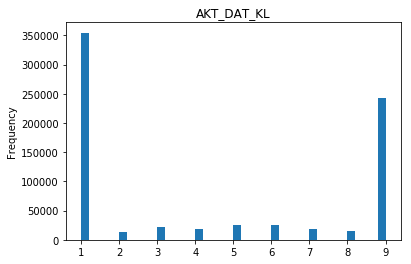

289920


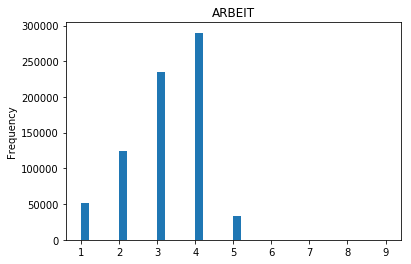

182290


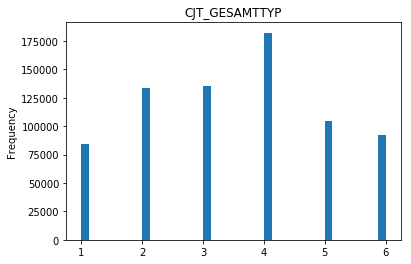

200965


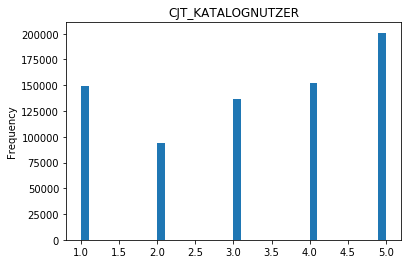

279021


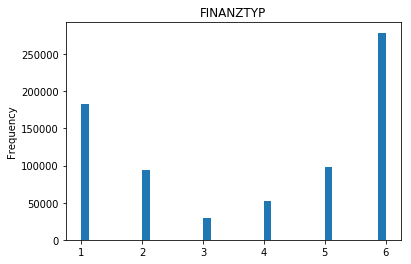

335629


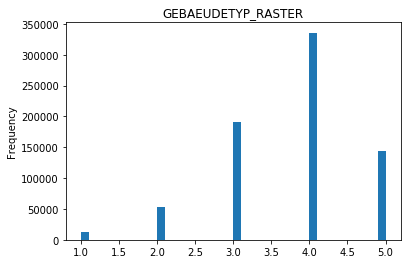

140580


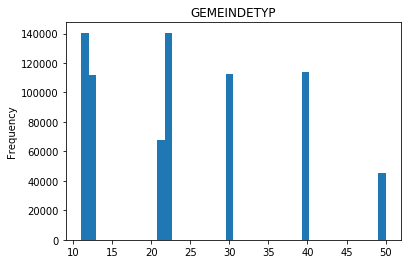

118741


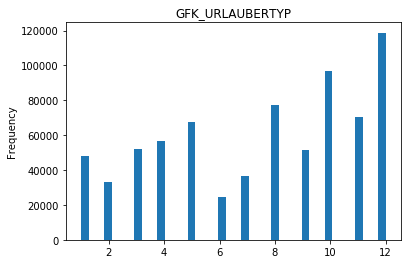

292985


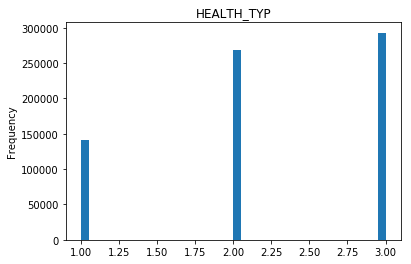

273223


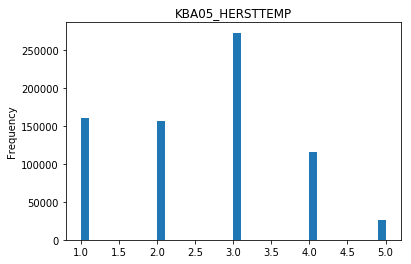

268417


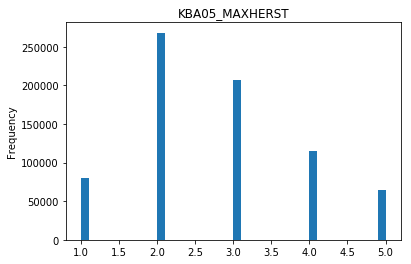

456222
KBA13_BAUMAX has 456222 rows of value 1.0.


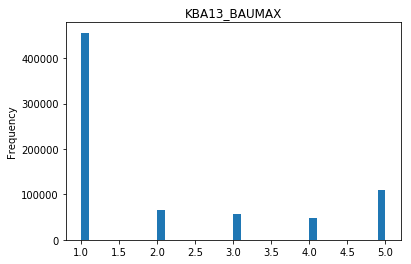

331618


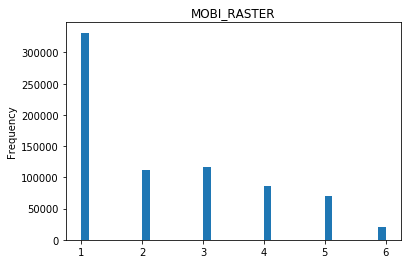

188405


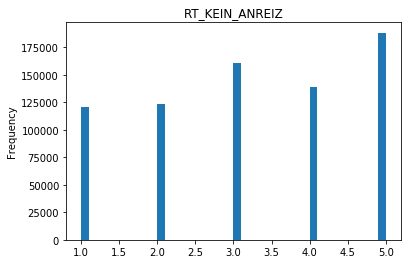

300984


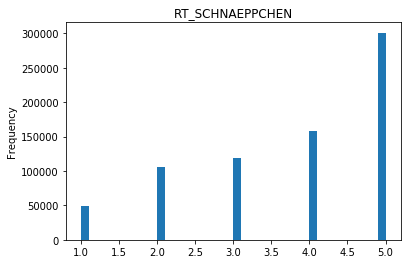

160436


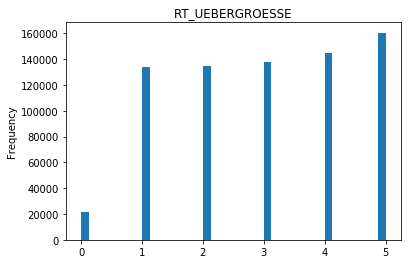

222704


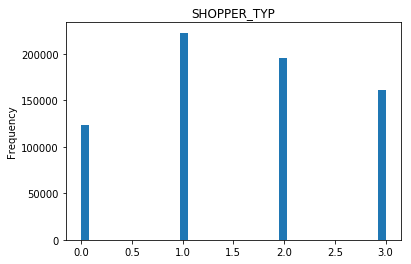

516393
STRUKTURTYP has 516393 rows of value 3.0.


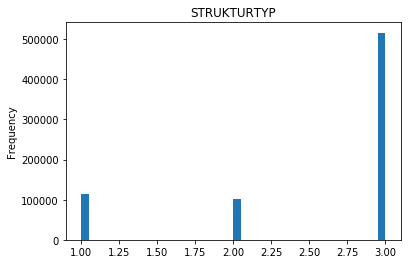

213557


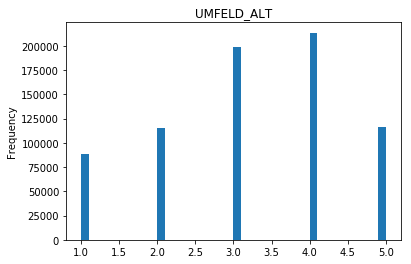

595495
VHA has 595495 rows of value 0.0.


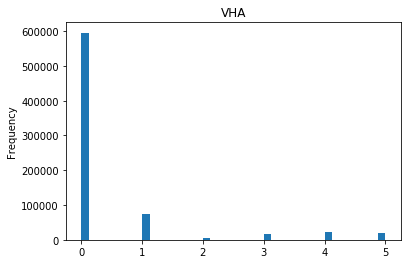

260843


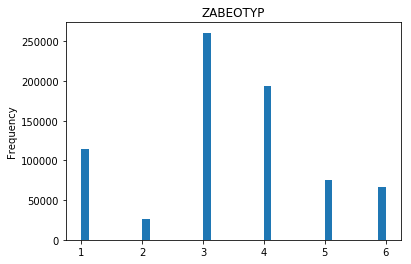

232410


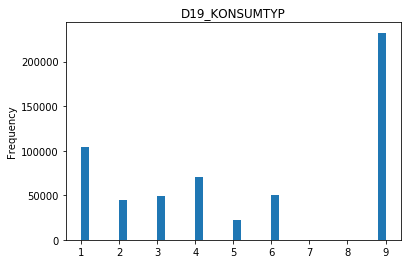

In [178]:
categorical_attributes = att_type[att_type["type"].isin(["?categorical","categorical"])]["attribute"].values
print("Categorical attributes: \n"
      "{}.".format(categorical_attributes))
print("")

mixed_attributes = att_type[att_type["type"].isin(["mixed","?mixed"])]["attribute"].values
print("Mixed type attributes: \n"
      "{}.".format(mixed_attributes))
print("")


#attributes that needs engineering
engineered_attributes = att_type[att_type["action"].isin(["engineering"])]["attribute"].values
print("Attributes that need engineering: \n"
      "{}.".format(engineered_attributes))
print("")


#attributes that needs to be dropped
droped_attributes = att_type[att_type["action"].isin(["drop"])]["attribute"].values
print("Attributes that needs to be dropped: \n"
      "{}.".format(droped_attributes))
print("")


#categorical attributes that need to be re-encoded (one hot encoded) 
reencoded_attributes = att_type[att_type["action"].isin(["onehot"])]["attribute"].values
print("Categorical attributes that need to be Re-Encoded: \n"
      "{}.".format(reencoded_attributes))
print("")

for att in reencoded_attributes:
    n_most_popular = azdias_few_nan[att].value_counts().values[0]
    most_popular = azdias_few_nan[att].value_counts().index[0]
    print(n_most_popular)
    if n_most_popular > 0.5*azdias_few_nan.shape[0]:
        print("{} has {} rows of value {}.".format(att, n_most_popular, most_popular))
    ax = azdias_few_nan[att].plot(kind='hist', bins=40)
    ax.set_title(att)
    plt.show()
    plt.close()

In [24]:
#Drop attributes
print(azdias_few_nan.shape)
azdias_few_nan.drop(droped_attributes, axis=1, inplace=True)
print(azdias_few_nan.shape)

(736407, 326)
(736407, 305)


In [25]:
#re-encode categorical attributes
print(azdias_few_nan.shape)
reencoded_azdias = pd.get_dummies(azdias_few_nan, columns=reencoded_attributes, drop_first=True,)
print(reencoded_azdias.shape)

(736407, 305)
(736407, 388)


In [26]:
#O -> 0, W -> 1
reencoded_azdias['OST_WEST_KZ'].replace(['O','W'], [0, 1], inplace=True)
#reencoded_azdias['OST_WEST_KZ'].value_counts()

In [51]:
#change EINGEFUEGT_AM to time format
reencoded_azdias["EINGEFUEGT_AM"][:2].dtype

reencoded_azdias["EINGEFUEGT_AM"] = pd.to_datetime(reencoded_azdias["EINGEFUEGT_AM"], format='%Y/%m/%d %H:%M')
reencoded_azdias["EINGEFUEGT_AM"] = reencoded_azdias["EINGEFUEGT_AM"].dt.year

reencoded_azdias["EINGEFUEGT_AM"][:10]

1     1970
2     1970
3     1970
4     1970
5     1970
6     1970
7     1970
8     1970
9     1970
10    1970
Name: EINGEFUEGT_AM, dtype: int64

#### Engineer Mixed-Type Features

In [52]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
#print(reencoded_azdias["PRAEGENDE_JUGENDJAHRE"].value_counts())
'''
### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)
'''

#create new binary attribute MOVEMENT with values Avantgarde (0) vs Mainstream (1)
reencoded_azdias['MOVEMENT'] = reencoded_azdias['PRAEGENDE_JUGENDJAHRE']
reencoded_azdias['MOVEMENT'].replace([-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], [np.nan,np.nan,1,2,1,2,1,2,2,1,2,1,2,1,2,1,2], inplace=True) 

#create new ordinal attribute GENERATION_DECADE with values 40s, 50s 60s ... encoded as 4, 5, 6 ...
reencoded_azdias['GENERATION_DECADE'] = reencoded_azdias['PRAEGENDE_JUGENDJAHRE']
reencoded_azdias['GENERATION_DECADE'].replace([-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], [np.nan,np.nan,4,4,5,5,6,6,6,7,7,8,8,8,8,9,9], inplace=True) 

#print(reencoded_azdias['MOVEMENT'])
#print(reencoded_azdias['GENERATION_DECADE'])

#delete 'PRAEGENDE_JUGENDJAHRE'
reencoded_azdias.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)

KeyError: 'PRAEGENDE_JUGENDJAHRE'

In [93]:
def engineer_PRAEGENDE_JUGENDJAHRE(df):
    '''
    Engineer two new attributes from PRAEGENDE_JUGENDJAHRE: MOVEMENT and GENERATION_DECADE

    PRAEGENDE_JUGENDJAHRE initial encoding
    Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
    - -1: unknown
    -  0: unknown
    -  1: 40s - war years (Mainstream, E+W)
    -  2: 40s - reconstruction years (Avantgarde, E+W)
    -  3: 50s - economic miracle (Mainstream, E+W)
    -  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
    -  5: 60s - economic miracle (Mainstream, E+W)
    -  6: 60s - generation 68 / student protestors (Avantgarde, W)
    -  7: 60s - opponents to the building of the Wall (Avantgarde, E)
    -  8: 70s - family orientation (Mainstream, E+W)
    -  9: 70s - peace movement (Avantgarde, E+W)
    - 10: 80s - Generation Golf (Mainstream, W)
    - 11: 80s - ecological awareness (Avantgarde, W)
    - 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
    - 13: 80s - Swords into ploughshares (Avantgarde, E)
    - 14: 90s - digital media kids (Mainstream, E+W)
    - 15: 90s - ecological awareness (Avantgarde, E+W)
    
    Final encooding:
    
    "MOVEMENT": 
    - 1: Mainstream
    - 2: Avantgarde

    “GENERATION_DECADE”:
    - 4: 40s
    - 5: 50s
    - 6: 60s
    - 7: 70s
    - 8: 80s
    - 9: 90s

    Input:
        df (DataFrame): dataframe that has PRAEGENDE_JUGENDJAHRE attribute

    Output:
        df_new (DataFrame): dataframe with new attributes MOVEMENT and GENERATION, PRAEGENDE_JUGENDJAHRE attribute 
                            is removed
    
    '''

    #create new binary attribute MOVEMENT with values Avantgarde (0) vs Mainstream (1)
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE']
    df['MOVEMENT'].replace([-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
                           [np.nan,np.nan,1,2,1,2,1,2,2,1,2,1,2,1,2,1,2], inplace=True) 

    #create new ordinal attribute GENERATION_DECADE with values 40s, 50s 60s ... encoded as 4, 5, 6 ...
    df['GENERATION_DECADE'] = df['PRAEGENDE_JUGENDJAHRE']
    df['GENERATION_DECADE'].replace([-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
                                    [np.nan,np.nan,4,4,5,5,6,6,6,7,7,8,8,8,8,9,9], inplace=True) 

    #delete 'PRAEGENDE_JUGENDJAHRE'
    df_new = df.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)
    
    return df_new

In [53]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
'''
### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown
'''

#print(reencoded_azdias['CAMEO_INTL_2015'].value_counts())

#create new ordinal attribute WEALTH
reencoded_azdias['WEALTH'] = reencoded_azdias['CAMEO_INTL_2015'].str[:1].astype(float)
#reencoded_azdias['WEALTH'] = reencoded_azdias['WEALTH'].apply(lambda x: float(x))

#create new ordinal attribute LIFE_AGE
reencoded_azdias['LIFE_AGE'] = reencoded_azdias['CAMEO_INTL_2015'].str[1:2].astype(float)
#reencoded_azdias['LIFE_AGE'] = reencoded_azdias['LIFE_AGE'].apply(lambda x: float(x))

#print(reencoded_azdias['AGE'].value_counts())

#delete 'CAMEO_INTL_2015'
reencoded_azdias.drop(['CAMEO_INTL_2015'], axis=1, inplace=True)

KeyError: 'CAMEO_INTL_2015'

In [94]:
def engineer_CAMEO_INTL_2015(df):
    '''
    Engineer two new attributes from CAMEO_INTL_2015: WEALTH and LIFE_AGE

    CAMEO_INTL_2015 initial encoding
    German CAMEO: Wealth / Life Stage Typology, mapped to international code
    - -1: unknown
    - 11: Wealthy Households - Pre-Family Couples & Singles
    - 12: Wealthy Households - Young Couples With Children
    - 13: Wealthy Households - Families With School Age Children
    - 14: Wealthy Households - Older Families &  Mature Couples
    - 15: Wealthy Households - Elders In Retirement
    - 21: Prosperous Households - Pre-Family Couples & Singles
    - 22: Prosperous Households - Young Couples With Children
    - 23: Prosperous Households - Families With School Age Children
    - 24: Prosperous Households - Older Families & Mature Couples
    - 25: Prosperous Households - Elders In Retirement
    - 31: Comfortable Households - Pre-Family Couples & Singles
    - 32: Comfortable Households - Young Couples With Children
    - 33: Comfortable Households - Families With School Age Children
    - 34: Comfortable Households - Older Families & Mature Couples
    - 35: Comfortable Households - Elders In Retirement
    - 41: Less Affluent Households - Pre-Family Couples & Singles
    - 42: Less Affluent Households - Young Couples With Children
    - 43: Less Affluent Households - Families With School Age Children
    - 44: Less Affluent Households - Older Families & Mature Couples
    - 45: Less Affluent Households - Elders In Retirement
    - 51: Poorer Households - Pre-Family Couples & Singles
    - 52: Poorer Households - Young Couples With Children
    - 53: Poorer Households - Families With School Age Children
    - 54: Poorer Households - Older Families & Mature Couples
    - 55: Poorer Households - Elders In Retirement
    - XX: unknown

    Final encooding:
    
    "WEALTH"
    - 1: Wealthy Households
    - 2: Prosperous Households
    - 3: Comfortable Households
    - 4: Less Affluent Households
    - 5: Poorer Households

    "LIFE_AGE"
    - 1: Pre-Family Couples & Singles
    - 2: Young Couples With Children
    - 3: Families With School Age Children
    - 4: Older Families &  Mature Couples
    - 5: Elders In Retirement
    
    Input:
        df (DataFrame): dataframe that has CAMEO_INTL_2015 attribute

    Output:
        df_new (DataFrame): dataframe with new attributes WEALRH and LIFE_AGE; CAMEO_INTL_2015 attribute 
                            is removed
    
    '''
    #create new ordinal attribute WEALTH
    df['WEALTH'] = df['CAMEO_INTL_2015'].str[:1].astype(float)


    #create new ordinal attribute LIFE_AGE
    df['LIFE_AGE'] = df['CAMEO_INTL_2015'].str[1:2].astype(float)

    #delete 'CAMEO_INTL_2015'
    df_new = df.drop(['CAMEO_INTL_2015'], axis=1)
    
    return df_new
    

KeyError: 'WOHNLAGE'

In [ ]:
#Investigate WOHNLAGE feature
'''
### 3.7. WOHNLAGE
Neighborhood quality (or rural flag)
- -1: unknown
-  0: no score calculated
-  1: very good neighborhood
-  2: good neighborhood
-  3: average neighborhood
-  4: poor neighborhood
-  5: very poor neighborhood
-  7: rural neighborhood
-  8: new building in rural neighborhood'''

print(reencoded_azdias['WOHNLAGE'].value_counts())
#number of rural neighborhood
rural = reencoded_azdias['WOHNLAGE'].value_counts()[1] + reencoded_azdias['WOHNLAGE'].value_counts()[7]
print("Percent of rural that will be missing in quality of neighborhood:", (rural/total).round(2))


#create new binary attribute RURAL_NEIGHBORHOOD with values Rural (1) vs NotRural(0)
reencoded_azdias['RURAL_NEIGHBORHOOD'] = reencoded_azdias['WOHNLAGE']
reencoded_azdias['RURAL_NEIGHBORHOOD'].replace([-1,0,1,2,3,4,5,7,8], [np.nan,np.nan,0,0,0,0,0,1,1], inplace=True) 

#One of the options is to create additional QUALITY_NEIGHBORHOOD feature however there will be 24% of missing data

print(reencoded_azdias['WOHNLAGE'].head())
print(reencoded_azdias['RURAL_NEIGHBORHOOD'].head())

#delete 'WOHNLAGE'
reencoded_azdias.drop(['WOHNLAGE'], axis=1, inplace=True)

In [95]:
def engineer_WOHNLAGE(df):
    '''
    Engineer RURAL_NEIGHBORHOOD from WOHNLAGE attribute
    "WOHNLAGE" feature could be divided into “RURAL_NEIGHBORHOOD” and “QUALITY_NEIGHBORHOOD”. 
    However, there are 24% of rural data that will have missing values in "QUALITY_NEIGHBORHOOD” 
    feature, therefore only binary "RURAL_NEIGHBORHOOD" feature was created inplace of "WOHNLAGE"

    Initial encoding of WOHNLAGE:
    Neighborhood quality (or rural flag)
    - -1: unknown
    -  0: no score calculated
    -  1: very good neighborhood
    -  2: good neighborhood
    -  3: average neighborhood
    -  4: poor neighborhood
    -  5: very poor neighborhood
    -  7: rural neighborhood
    -  8: new building in rural neighborhood
    
    Final encooding:

    "RURAL_NEIGBORHOOD"
    - 0: Not Rural
    - 1: Rural
    
    Input:
        df (DataFrame): dataframe that has WOHNLAGE attribute

    Output:
        df_new (DataFrame): dataframe with new attribute RURAL_NEIGBORHOOD; WOHNLAGE attribute 
                            is removed
    

'''

    #create new binary attribute RURAL_NEIGHBORHOOD with values Rural (1) vs NotRural(0)
    df['RURAL_NEIGHBORHOOD'] = df['WOHNLAGE']
    df['RURAL_NEIGHBORHOOD'].replace([-1,0,1,2,3,4,5,7,8], [np.nan,np.nan,0,0,0,0,0,1,1], inplace=True) 

    #delete 'WOHNLAGE'
    df_new = df.drop(['WOHNLAGE'], axis=1)
    
    return df_new

In [31]:
#Investigate PLZ8_BAUMAX feature
'''
### 8.6. PLZ8_BAUMAX
Most common building type within the PLZ8 region
- -1: unknown
-  0: unknown
-  1: mainly 1-2 family homes
-  2: mainly 3-5 family homes
-  3: mainly 6-10 family homes
-  4: mainly 10+ family homes
-  5: mainly business buildings
'''
print(reencoded_azdias['PLZ8_BAUMAX'].value_counts())

#create new binary attribute PLZ8_BAUMAX_BUSINESS with values Business (1) vs Not Business(0)
reencoded_azdias['PLZ8_BAUMAX_BUSINESS'] = reencoded_azdias['PLZ8_BAUMAX']
reencoded_azdias['PLZ8_BAUMAX_BUSINESS'].replace([1,2,3,4,5], [0,0,0,0,1], inplace=True) 

#create new ordinal attribute PLZ8_BAUMAX_FAMILY with from 1 to 4 encoded as in data dictionary
reencoded_azdias['PLZ8_BAUMAX_FAMILY'] = reencoded_azdias['PLZ8_BAUMAX']
reencoded_azdias['PLZ8_BAUMAX_FAMILY'].replace([5], [0], inplace=True) 

print(reencoded_azdias['PLZ8_BAUMAX'].head())
print(reencoded_azdias['PLZ8_BAUMAX_BUSINESS'].head())
print(reencoded_azdias['PLZ8_BAUMAX_FAMILY'].head())

#delete 'PLZ8_BAUMAX'
reencoded_azdias.drop(['PLZ8_BAUMAX'], axis=1, inplace=True)

1.0    469944
5.0     91676
2.0     67734
4.0     54335
3.0     49216
Name: PLZ8_BAUMAX, dtype: int64
1    1.0
2    1.0
3    1.0
4    2.0
5    1.0
Name: PLZ8_BAUMAX, dtype: float64
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: PLZ8_BAUMAX_BUSINESS, dtype: float64
1    1.0
2    1.0
3    1.0
4    2.0
5    1.0
Name: PLZ8_BAUMAX_FAMILY, dtype: float64


In [99]:
def engineer_PLZ8_BAUMAX(df):
    '''
    Engineer PLZ8_BAUMAX_BUSINESS and PLZ8_BAUMAX_FAMILY attributes from PLZ8_BAUMAX attribute
   
    PLZ8_BAUMAX initial encoding:
    Most common building type within the PLZ8 region
    - -1: unknown
    -  0: unknown
    -  1: mainly 1-2 family homes
    -  2: mainly 3-5 family homes
    -  3: mainly 6-10 family homes
    -  4: mainly 10+ family homes
    -  5: mainly business buildings
    
    Final encoding:
    “PLZ8_BAUMAX_BUSINESS”
    - 0: Not Business
    - 1: Business

    “PLZ8_BAUMAX_FAMILY”
    - 0: 0 families
    - 1: mainly 1-2 family homes
    - 2: mainly 3-5 family homes
    - 3: mainly 6-10 family homes
    - 4: mainly 10+ family homes
    
    Input:
        df (DataFrame): dataframe that has PLZ8_BAUMAX attribute

    Output:
        df_new (DataFrame): dataframe with new attributes PLZ8_BAUMAX_BUSINESS and PLZ8_BAUMAX_FAMILY; PLZ8_BAUMAX attribute 
                            is removed
    
    '''

    #create new binary attribute PLZ8_BAUMAX_BUSINESS with values Business (1) vs Not Business(0)
    df['PLZ8_BAUMAX_BUSINESS'] = df['PLZ8_BAUMAX']
    df['PLZ8_BAUMAX_BUSINESS'].replace([1,2,3,4,5], [0,0,0,0,1], inplace=True) 

    #create new ordinal attribute PLZ8_BAUMAX_FAMILY with from 1 to 4 encoded as in data dictionary
    df['PLZ8_BAUMAX_FAMILY'] = df['PLZ8_BAUMAX']
    df['PLZ8_BAUMAX_FAMILY'].replace([5], [0], inplace=True) 

    #delete 'PLZ8_BAUMAX'
    df_new = df.drop(['PLZ8_BAUMAX'], axis=1)
    
    return df_new

In [102]:
#check whether all columns are of numeric dtype
def check_columns_numeric(df):
    '''
    Check if all columns are numeric
    
    Input:
        df (DataFrame)
    Output:
        result (Bool): all numeric columns True or False
    '''
    
    result = True
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column])==False:
            print("{} is not numeric.".format(column))
            #print(df[column])
            result = False
            
    return result

In [87]:
reencoded_azdias.shape

(736407, 391)

In [143]:
def clean_data(df, test_data=False):
    '''
    Perform feature trimming, re-encoding, and engineering for given DataFrame 
    
    Input:
        df (DataFrame)
        test_data (Bool): df is test data, so no rows should be dropped, default=False
    Output:
        cleaned_df (DataFrame): cleaned df DataFrame
    '''
    
    # convert missing value codes into NaNs, ... 
    print("Convert missing value codes into NaNs")
    missing_keys_dict = create_missing_key_dict('DIAS_Attributes_Values_2017.csv')
    convert_keys_to_nan(df, missing_keys_dict)
    print(df.shape)
    #drops columns with more than 30% of missing values
    print("Drop columns with more than 30% of missing values")
    dropped_columns = ['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'D19_BANKEN_LOKAL', 'ALTER_KIND2', 'D19_DIGIT_SERV', 
     'D19_BIO_OEKO', 'D19_TIERARTIKEL', 'D19_NAHRUNGSERGAENZUNG', 'D19_GARTEN', 'D19_LEBENSMITTEL', 
     'D19_WEIN_FEINKOST', 'D19_ENERGIE', 'D19_BANKEN_REST', 'D19_BILDUNG', 'ALTER_KIND1', 
     'D19_BEKLEIDUNG_GEH', 'D19_RATGEBER', 'D19_SAMMELARTIKEL', 'D19_FREIZEIT', 'D19_BANKEN_GROSS', 
     'D19_SCHUHE', 'D19_HANDWERK', 'D19_TELKO_REST', 'D19_DROGERIEARTIKEL', 'D19_LOTTO', 'D19_VERSAND_REST', 
     'D19_BANKEN_DIREKT', 'D19_TELKO_MOBILE', 'D19_HAUS_DEKO', 'D19_BEKLEIDUNG_REST', 'AGER_TYP', 
     'D19_VERSICHERUNGEN', 'EXTSEL992', 'D19_TECHNIK', 'D19_VOLLSORTIMENT', 'KK_KUNDENTYP', 'D19_SONSTIGE', 
     'KBA05_BAUMAX', 'ALTER_HH']
    
    df_cleaned = df.drop(dropped_columns,axis=1)

    #obtain dropped attributes from attribute_types.csv
    att_type = pd.read_csv('attribute_types.csv', sep=',')
    droped_attributes = att_type[att_type["action"].isin(["drop"])]["attribute"].values
    #print(len(droped_attributes))
    print("Drop columns indicated in attribute_types.csv file")
    df_cleaned = df_cleaned.drop(droped_attributes,axis=1)
    
    
    print(df_cleaned.shape)
    #remove rows with more than 25 missing attributes if it not a testing data, skip this step if it is test data
    df_cleaned['n_missing'] = df_cleaned.isnull().sum(axis=1)
    ax = df_cleaned["n_missing"].plot(kind='hist', bins=40)
    
    if not test_data:
        print("Remove rows with more than 25 missing attributes")
        df_cleaned = df_cleaned[df_cleaned["n_missing"]<= 25].drop("n_missing", axis=1)
    else:
        pass
    
    print(df_cleaned.shape)
    #categorical attributes that need to be re-encoded (one hot encoded) 
    reencoded_attributes = att_type[att_type["action"].isin(["onehot"])]["attribute"].values
    #re-encode attributes
    print("Re-encode categorical attributes")
    df_cleaned = pd.get_dummies(df_cleaned, columns=reencoded_attributes, drop_first=True)

    #O -> 0, W -> 1
    print("Reencode OST_WEST_KZ attribute")
    df_cleaned['OST_WEST_KZ'].replace(['O','W'], [0, 1], inplace=True)
    
    #change EINGEFUEGT_AM to year format
    print("Change EINGEFUEGT_AM to year")
    df_cleaned["EINGEFUEGT_AM"] = pd.to_datetime(df_cleaned["EINGEFUEGT_AM"], format='%Y/%m/%d %H:%M')
    df_cleaned["EINGEFUEGT_AM"] = df_cleaned["EINGEFUEGT_AM"].dt.year
    
    print(df_cleaned.shape)
    #engineer PRAEGENDE_JUGENDJAHRE
    print("Engineer PRAEGENDE_JUGENDJAHRE")
    df_cleaned = engineer_PRAEGENDE_JUGENDJAHRE(df_cleaned)
    
    #engineer CAMEO_INTL_2015
    print("Engineer CAMEO_INTL_2015")
    df_cleaned = engineer_CAMEO_INTL_2015(df_cleaned)
    
    #engineer_WOHNLAGE
    print("Engineer WOHNLAGE")
    df_cleaned = engineer_WOHNLAGE(df_cleaned)
    
    #engineer_PLZ8_BAUMAX
    print("Engineer PLZ8_BAUMAX")
    df_cleaned = engineer_PLZ8_BAUMAX(df_cleaned)  
    
    #change object type of CAMEO_DEUG_2015 to numeric type
    df_cleaned["CAMEO_DEUG_2015"] = pd.to_numeric(df_cleaned["CAMEO_DEUG_2015"])
    
    #check all columns are numeric
    #print("Check if all columns are numeric type")
    if check_columns_numeric(df_cleaned):
        print("All columns are numeric")

    print(df_cleaned.shape)
    return df_cleaned

In [144]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', ';')

/Users/maxim/miniconda/envs/Python_36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Convert missing value codes into NaNs
Attribute BIP_FLAG is not available in DataFrame.
Attribute CAMEO_DEUINTL_2015 is not available in DataFrame.
Attribute D19_KK_KUNDENTYP is not available in DataFrame.
Attribute GEOSCORE_KLS7 is not available in DataFrame.
Attribute HAUSHALTSSTRUKTUR is not available in DataFrame.
Attribute KBA13_CCM_1400_2500 is not available in DataFrame.
Attribute SOHO_FLAG is not available in DataFrame.
Attribute WACHSTUMSGEBIET_NB is not available in DataFrame.
Attribute D19_BUCH is not available in DataFrame.
Attribute D19_KINDERARTIKELD19_KOSMETIK is not available in DataFrame.
(891221, 366)
Drop columns with more than 30% of missing values
Drop columns indicated in attribute_types.csv file
(891221, 305)
Remove rows with more than 25 missing attributes
(737231, 305)
Re-encode categorical attributes
Reencode OST_WEST_KZ attribute
Change EINGEFUEGT_AM to year
(737231, 388)
Engineer PRAEGENDE_JUGENDJAHRE
Engineer CAMEO_INTL_2015
Engineer WOHNLAGE
Engineer PLZ8_

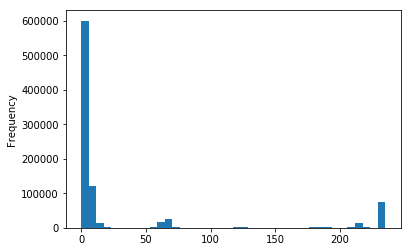

In [145]:
#clean general demographics data
azdias_cleaned = clean_data(azdias)

print(azdias_cleaned.shape)

Convert missing value codes into NaNs
Attribute BIP_FLAG is not available in DataFrame.
Attribute CAMEO_DEUINTL_2015 is not available in DataFrame.
Attribute D19_KK_KUNDENTYP is not available in DataFrame.
Attribute GEOSCORE_KLS7 is not available in DataFrame.
Attribute HAUSHALTSSTRUKTUR is not available in DataFrame.
Attribute KBA13_CCM_1400_2500 is not available in DataFrame.
Attribute SOHO_FLAG is not available in DataFrame.
Attribute WACHSTUMSGEBIET_NB is not available in DataFrame.
Attribute D19_BUCH is not available in DataFrame.
Attribute D19_KINDERARTIKELD19_KOSMETIK is not available in DataFrame.
(153986, 366)
Drop columns with more than 30% of missing values
Drop columns indicated in attribute_types.csv file
Re-encode categorical attributes
Reencode OST_WEST_KZ attribute
Change EINGEFUEGT_AM to year
(153986, 389)
Engineer PRAEGENDE_JUGENDJAHRE
Engineer CAMEO_INTL_2015
Engineer WOHNLAGE
Engineer PLZ8_BAUMAX
All columns are numeric
(153986, 392)


(153986, 392)

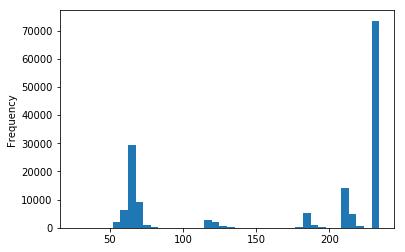

In [122]:
azdias_2 = azdias[~azdias.index.isin(azdias_cleaned.index)]
azdias_nan = azdias_2.copy()
azdias_nan.shape
azdias_nan = clean_data(azdias_nan, True)
azdias_nan.shape

### Transforming Skewed Continuous Features###

A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number. Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized

Numerical continuous attributes: 
['ANZ_HAUSHALTE_AKTIV' 'ANZ_HH_TITEL' 'ANZ_PERSONEN' 'ANZ_TITEL'
 'EINGEZOGENAM_HH_JAHR' 'GEBURTSJAHR' 'KBA13_ANZAHL_PKW' 'MIN_GEBAEUDEJAHR'].



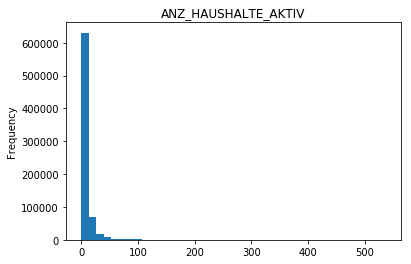

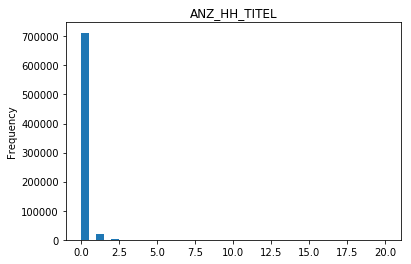

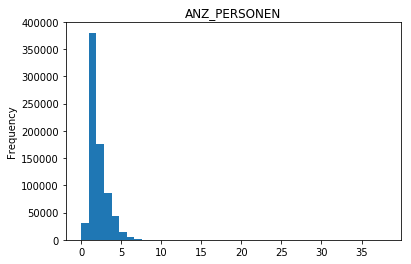

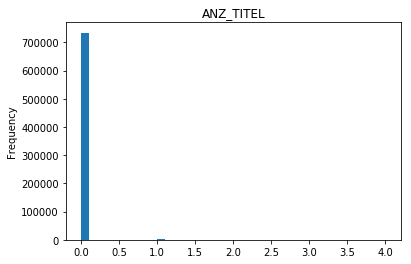

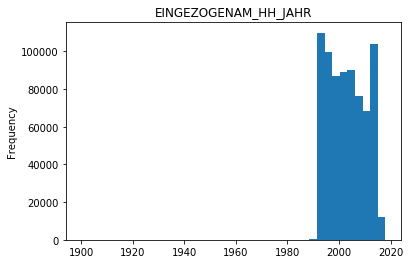

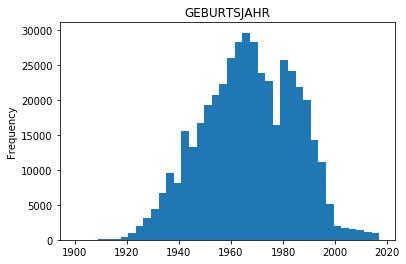

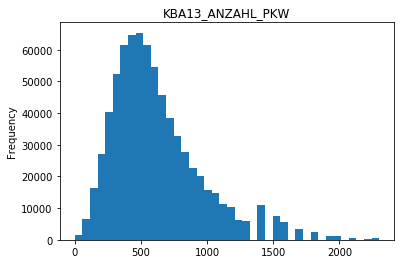

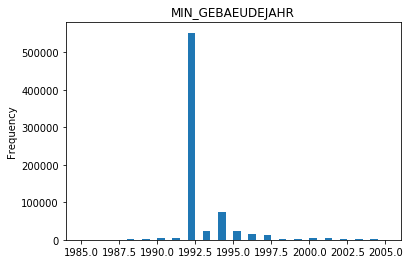

In [146]:
# Visualize skewed continuous features of original data
continuous_attributes = att_type[att_type["type"]=="numeric"]["attribute"].values
print("Numerical continuous attributes: \n"
      "{}.".format(continuous_attributes))
print("")

for att in continuous_attributes:
    ax = azdias_cleaned[att].plot(kind="hist", bins=40)
    ax.set_title(att)
    plt.show()
    plt.close()

In [147]:
#sns.pairplot(azdias_cleaned, plot_kws=dict(alpha=0.5))
#plt.show()
azdias_cleaned[continuous_attributes].describe()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,EINGEZOGENAM_HH_JAHR,GEBURTSJAHR,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR
count,737231.000000,733906.000000,737231.000000,737231.000000,737231.000000,449843.000000,737231.000000,737231.000000
mean,8.176837,0.039181,1.738516,0.004140,2003.403926,1966.926915,618.049594,1992.708367
std,15.107720,0.311972,1.163954,0.068243,7.052770,17.856637,337.449194,1.820079
min,0.000000,0.000000,0.000000,0.000000,1900.000000,1900.000000,0.000000,1985.000000
25%,2.000000,0.000000,1.000000,0.000000,1997.000000,1954.000000,384.000000,1992.000000
50%,4.000000,0.000000,1.000000,0.000000,2003.000000,1967.000000,548.000000,1992.000000
75%,9.000000,0.000000,2.000000,0.000000,2009.000000,1981.000000,775.000000,1992.000000
max,536.000000,20.000000,38.000000,4.000000,2018.000000,2017.000000,2300.000000,2005.000000


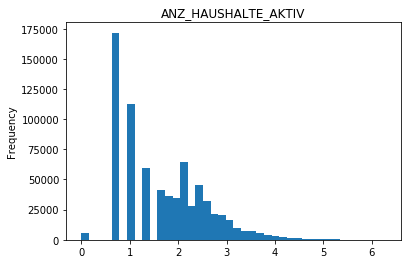

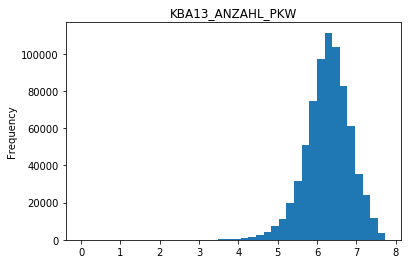

In [148]:
log_transform_attributes = ['ANZ_HAUSHALTE_AKTIV','KBA13_ANZAHL_PKW']

from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log1p, validate=True)
azdias_cleaned[log_transform_attributes] = transformer.transform(azdias_cleaned[log_transform_attributes])

for att in log_transform_attributes:
    ax = azdias_cleaned[att].plot(kind="hist", bins=40)
    ax.set_title(att)
    plt.show()
    plt.close()

In [185]:
print("Number of rows with zero value in ANZ_HH_TITEL {}.".format(azdias_cleaned['ANZ_HH_TITEL'].value_counts().values[0]))
print("Number of rows with zero value in ANZ_TITEL {}.".format(azdias_cleaned['ANZ_TITEL'].value_counts().values[0]))
#Drop these two attributes from analysis

Number of rows with zero value in ANZ_HH_TITEL 712274.
Number of rows with zero value in ANZ_TITEL 734369.


In [124]:
def tukey_rule(df, column_name):
    '''
    Function that uses the Tukey rule to detect outliers in a dataframe column 
    and then removes that entire row from the data frame
    
    Input:
        df (DataFrame): DataFrame
        column_name (str): column name base on wich outliers will be analyzed and removed
    Output:
        df_reduced (DataFrame): new DataFrame with the outliers eliminated
        
    '''
    
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)

    IQR = Q3 - Q1

    max_value = Q3 + 1.5 * IQR
    min_value = Q1 - 1.5 * IQR
    
    df_reduced = df[~((df[column_name] > max_value) | (df[column_name] < min_value))]
    

    
    #data_frame[(data_frame[column_name] < max_value) & (data_frame[column_name] > min_value)]

    return df_reduced

In [125]:
num_attributes = att_type[att_type["type"]=="numeric"]["attribute"].values
print("Numerical attributes: \n"
      "{}.".format(num_attributes))
print("")

azdias_outlier_removed = azdias_cleaned.copy()

for column in num_attributes :
    azdias_outlier_removed = tukey_rule(azdias_outlier_removed, column)
    print(azdias_outlier_removed.shape)

Numerical attributes: 
['ANZ_HAUSHALTE_AKTIV' 'ANZ_HH_TITEL' 'ANZ_PERSONEN' 'ANZ_TITEL'
 'EINGEZOGENAM_HH_JAHR' 'GEBURTSJAHR' 'KBA13_ANZAHL_PKW' 'MIN_GEBAEUDEJAHR'].

(678370, 391)
(664960, 391)
(603457, 391)
(603454, 391)
(603451, 391)
(603451, 391)
(575074, 391)
(434370, 391)


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')